In [10]:
import argparse

import azureml.core
from azureml.core import Experiment,Workspace, Run
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails
from collections import defaultdict
import cv2
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import genfromtxt
import os
import pandas as pd
from PIL import Image, ImageFilter
from skimage import io as io
from skimage import exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import shutil
from time import time
import traceback
import timeit
import urllib.request

In [11]:
print(azureml.core.VERSION)

subscription_id = os.getenv("SUBSCRIPTION_ID", default="9bce0414-e6b9-4c79-b146-74018a4b09ac")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="Multi-label_classification")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")
try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except Exception as e:
    print(e)
    print("Workspace not accessible. Change your parameters or create a new workspace below")
    
cpu_cluster_name = "cpucluster"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cpucluster")
except ComputeTargetException:
    print("Creating new cpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2",
                                                           min_nodes=0,
                                                           max_nodes=4)

    # Create the cluster with the specified name and configuration
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
    
    # Wait for the cluster to complete, show the output log
    cpu_cluster.wait_for_completion(show_output=True)

gpu_cluster_name = "gpucluster"

# Verify that cluster does not exist already
try:
    gpu_cluster = ComputeTarget(workspace=ws, name=gpu_cluster_name)
    print("Found existing gpu cluster")
except ComputeTargetException:
    print("Creating new gpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_NC6",
                                                           min_nodes=0,
                                                           max_nodes=4)
    # Create the cluster with the specified name and configuration
    gpu_cluster = ComputeTarget.create(ws, gpu_cluster_name, compute_config)

    # Wait for the cluster to complete, show the output log
    gpu_cluster.wait_for_completion(show_output=True)


1.0.17
Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json
Workspace configuration succeeded. Skip the workspace creation steps below
Found existing cpucluster
Found existing gpu cluster


In [12]:
from azureml.core import Workspace

# Create the workspace using the specified parameters
ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
ws.get_details()

# write the details of the workspace to a configuration file to the notebook library
ws.write_config()

Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json


In [13]:
experiment_name = 'multi-class_classification'
exp = Experiment(workspace=ws, name=experiment_name)

In [14]:
# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. cpucluster


In [15]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
#ds.upload(src_dir='./data', target_path='data', overwrite=True, show_progress=True)

AzureBlob multilabelclas6598396697 azureml-blobstore-cd752475-573b-4cba-aa3c-7c61a96a4f83


In [16]:
script_folder = './coco-multi-label'
os.makedirs(script_folder, exist_ok=True)

In [8]:
with open("data/annotations/instances_train2014.json") as read_file:
    train = json.load(read_file)
with open("data/annotations/instances_val2014.json") as read_file:
    val = json.load(read_file)
with open("data/annotations/instances_train2014.json") as read_file:
    instances = json.load(read_file)
with open("data/annotations/person_keypoints_train2014.json") as read_file:
    keypoints = json.load(read_file)

Number of images in 2014 train: 82783
Number of annotations in 2014 train: 604907
Number of annotations/image in 2014 train: 7.307140354903785
82081
82081
Label density in 2014 train: 0.0913392544362973
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])


1person: 185316
2bicycle: 4955
3car: 30785
4motorcycle: 6021
5airplane: 3833
6bus: 4327
7train: 3159
8truck: 7050
9boat: 7590
10traffic light: 9159
11fire hydrant: 1316
13stop sign: 1372
14parking meter: 833
15bench: 6751
16bird: 7290
17cat: 3301
18dog: 3774
19horse: 4666
20sheep: 6654
21cow: 5686
22elephant: 3905
23bear: 903
24zebra: 3685
25giraffe: 3596
27backpack: 6200
28umbrella: 7865
31handbag: 8778
32tie: 4497
33suitcase: 4251
34frisbee: 1862
35skis: 4698
36snowboard: 1960
37sports ball: 4392
38kite: 6560
39baseball bat: 2400
40baseball glove: 2689
41skateboard: 4012
42surfboard: 4161
43tennis racket: 3411
44bottle: 16983
46wine glass: 5618
47cup: 14513
48fork: 3918
49knife: 5536
50spoon: 4287
51bowl: 10064
5

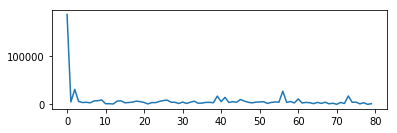


10 least used features 

[('hair drier', 135), ('toaster', 156), ('parking meter', 833), ('bear', 903), ('scissors', 1073), ('microwave', 1189), ('fire hydrant', 1316), ('stop sign', 1372), ('toothbrush', 1377)]



10 most used features 

[('handbag', 8778), ('traffic light', 9159), ('bowl', 10064), ('dining table', 11167), ('cup', 14513), ('bottle', 16983), ('book', 17315), ('chair', 27147), ('car', 30785), ('person', 185316)]




In [3]:
categories = train["categories"]
#print(categories)
train_images = train["images"]
#val_images = val["images"]
print("Number of images in 2014 train: "+str(len(train_images)))
#print("Number of images in 2014 val: "+str(len(val_images)) +"\n")
train_annotations = train["annotations"]
#print(train_annotations[1:20])
#val_annotations = val["annotations"]
print("Number of annotations in 2014 train: "+str(len(train_annotations)))
#print("Number of annotations in 2014 val: "+str(len(val_annotations)) + "\n")
print("Number of annotations/image in 2014 train: "+str(len(train_annotations)/len(train_images)))
#print("Number of annotations/image in 2014 val: " + str(len(val_annotations)/len(val_images)) + "\n")
train_categories = np.zeros(100, dtype=object)
#val_categories = np.zeros(100, dtype=object)
#itemsets = [[] for i in range(581922)]
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
print(len(itemsets))
unique_itemsets = []
for entry in itemsets:
    if(entry not in unique_itemsets):
        unique_itemsets.append(entry)
print(len(unique_itemsets))
#for annotation in val_annotations:
#    val_categories[annotation['category_id']] += 1
train_categories = train_categories[train_categories != 0]
#val_categories = val_categories[val_categories != 0]
print("Label density in 2014 train: "+str(len(train_annotations)/len(train_categories)/len(train_images)))
#print("Label density in 2014 val: "+str(len(val_annotations)/len(val_categories)/len(val_images)))
print(train.keys())
print("\n")
#print(images[1:10])
#print("\n")
#print(annotations[1:10])
#print("\n")
#print(categories)
for i in range(0, len(train_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(train_categories[i]))
    train_categories[i] = (categories[i]["name"], train_categories[i])
#for i in range(0, len(val_categories)):
    #print(categories[i]["name"] + ": " + str(train_categories[i]))
#    val_categories[i] = (categories[i]["name"], val_categories[i])
plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in train_categories])
#plt.subplot(212)
#plt.plot([i[1] for i in val_categories])
plt.show()
train_categories = sorted(train_categories, key=lambda tup: tup[1], reverse=False)
#val_categories = sorted(val_categories, key=lambda tup: tup[1], reverse=False)
print("\n10 least used features \n")
print(train_categories[0:9])
print("\n")
#print(val_categories[0:9])
print("\n10 most used features \n")
print(train_categories[-10:])
print("\n")
#print(val_categories[-10:])

In [4]:
image_id = 49 #9,25,30,34,36,49
def findAnnotations(id, property):
    items = []
    for annotation in train_annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items
items = findAnnotations(image_id, 'image_id')

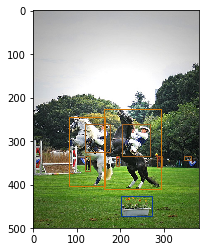

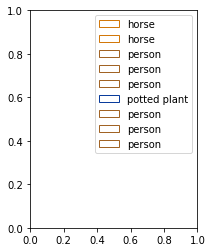

In [5]:
def findValueDictionary(dict,key,value, returnkey):
    for entry in dict:
        if entry[key] == value:
            return entry[returnkey]

image_id_string = str(image_id).zfill(12)
image = np.array(Image.open('data/train2014/COCO_train2014_'+ image_id_string +'.jpg'), dtype=np.uint8)
fig,ax = plt.subplots(1)
ax.imshow(image)
colors = np.random.random((len(categories)+10, 3))
i=0
bbox_list = []
item_list = []
for item in items:
    label = findValueDictionary(categories, 'id', item['category_id'], 'name')
    rect = patches.Rectangle((item['bbox'][0], (item['bbox'][1])), item['bbox'][2], item['bbox'][3],linewidth=1,edgecolor=colors[item['category_id']-1],facecolor='none', label= label)
    ax.add_patch(rect)
    bbox_list.append(rect)
    item_list.append(item['category_id'])
#print(items)
plt.figure(figsize=(3,4))
plt.legend(handles=bbox_list)
plt.show()

In [81]:
import argparse

import azureml.core
from azureml.core import Run
import cv2
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from skimage import io as io
from skimage import exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property):
    items = []
    for annotation in train_annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def getBoundingBoxesPicture(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (64, 64),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    image_bbox = np.asarray(bounded_images)
    bbox_annotations = np.asarray(bounded_annotations)
    return image_bbox,bbox_annotations

def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=6,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_img, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    hog_features = []
    dog_features = []
    daisy_features = []
    sift_features = []
    i = 0;
    for img in imgs:
        gray_img = rgb2gray(img)
        hog_features.append(calculateHogFeatures(gray_img,8,16,1))
        #dog_features.append(calculateDoG(gray_img))
        #sift_features.append(calculateSIFT(sift, gray_img))
        daisy_features.append(calculateDaisyFeatures(gray_img))
    return hog_features, daisy_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    t0 = time.time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Completed in %0.3fs" % (time.time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time.time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time.time() - t0))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
def randomForestFit(x_train, y_train, estimators, random_state):
    print("Fitting the classifier to train")
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators = estimators, random_state = random_state)
    rf.fit(x_train, y_train);
    print("Completed in %0.3fs" % (time.time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time.time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time.time() - t0))
    errors = abs(y_pred - y_test)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

data_folder = 'data'

path = "val2014/val2014/COCO_val2014_"
category = "category_id"
train_annotations = loadAnnotations(os.path.join(data_folder, 'annotations/instances_val2014.json'))
train_annotations = train_annotations["annotations"]
#category_imgs1 = getBoundingBoxesPicture(train_annotations, os.path.join(data_folder, path))
category_imgs2 = getBoundingBoxesPicture(findAnnotations(87, category), os.path.join(data_folder, path))
category_imgs3 = getBoundingBoxesPicture(findAnnotations(89, category), os.path.join(data_folder, path))
imgs = np.concatenate((category_imgs2[0], category_imgs3[0]))
#imgs = category_imgs1[0]
features = calculateFeatures(imgs)
np.save('features.npy', features)
labels = np.concatenate((category_imgs2[1], category_imgs3[1]))
#labels = category_imgs1[1]
x_train, x_test, y_train, y_test = train_test_split(
    features[0], labels, test_size=0.25, random_state=42)
svm = svmFit(x_train, y_train)
svmResults = svmPredict(x_test, y_test, svm)
#saveModel(svm, 'SVM_DAISY.sav')
os.makedirs('outputs', exist_ok=True)

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Fitting the classifier to train
Completed in 6.108s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the test set
Completed in 0.006s
              precision    recall  f1-score   support

          87       0.83      0.93      0.88       107
          89       0.22      0.09      0.12        23

   micro avg       0.78      0.78      0.78       130
   macro avg       0.52      0.51      0.50       130
weighted avg       0.72      0.78      0.74       130

[[100   7]
 [ 21   2]]


In [84]:
%%writefile $script_folder/train.py

import argparse

import azureml.core
from azureml.core import Run
import cv2
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from skimage import io as io
from skimage import exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property):
    items = []
    for annotation in train_annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def getBoundingBoxesPicture(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (64, 64),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    image_bbox = np.asarray(bounded_images)
    bbox_annotations = np.asarray(bounded_annotations)
    return image_bbox,bbox_annotations

def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=6,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_img, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    hog_features = []
    dog_features = []
    daisy_features = []
    sift_features = []
    i = 0;
    for img in imgs:
        gray_img = rgb2gray(img)
        hog_features.append(calculateHogFeatures(gray_img,8,16,1))
        #dog_features.append(calculateDoG(gray_img))
        #sift_features.append(calculateSIFT(sift, gray_img))
        daisy_features.append(calculateDaisyFeatures(gray_img))
    return hog_features, daisy_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    t0 = time.time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Completed in %0.3fs" % (time.time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time.time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time.time() - t0))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
def randomForestFit(x_train, y_train, estimators, random_state):
    print("Fitting the classifier to train")
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators = estimators, random_state = random_state)
    rf.fit(x_train, y_train);
    print("Completed in %0.3fs" % (time.time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    t0 = time.time()
    y_pred = model.predict(x_test)
    print("Completed in %0.3fs" % (time.time() - t0))
    errors = abs(y_pred - y_test)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()
data_folder = os.path.join(args.data_folder, 'data')
print('Data folder:', data_folder)
run = Run.get_context()

path = "val2014/COCO_val2014_"
category = "category_id"
train_annotations = loadAnnotations(os.path.join(data_folder, 'annotations/instances_val2014.json'))
train_annotations = train_annotations["annotations"]
#category_imgs1 = getBoundingBoxesPicture(train_annotations, os.path.join(data_folder, path))
category_imgs2 = getBoundingBoxesPicture(findAnnotations(87, category), os.path.join(data_folder, path))
category_imgs3 = getBoundingBoxesPicture(findAnnotations(89, category), os.path.join(data_folder, path))
imgs = np.concatenate((category_imgs2[0], category_imgs3[0]))
#imgs = category_imgs1[0]
features = calculateFeatures(imgs)
#np.save('features.npy', features)
labels = np.concatenate((category_imgs2[1], category_imgs3[1]))
#labels = category_imgs1[1]
x_train, x_test, y_train, y_test = train_test_split(
    features[0], labels, test_size=0.25, random_state=42)
svm = svmFit(x_train, y_train)
#saveModel(svm, 'SVM_DAISY.sav')
run.log('prediction', svmPredict(x_test, y_test, svm))
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=svm, filename='outputs/SVM.pkl')

Overwriting ./coco-multi-label/train.py


In [85]:
import shutil
shutil.copy('utils.py', script_folder)

'./coco-multi-label\\utils.py'

In [86]:
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
}

est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn', 'scikit-image', 'pillow', 'opencv'])

run = exp.submit(config=est)
run

from azureml.widgets import RunDetails
RunDetails(run).show()

run.wait_for_completion(show_output=True) # specify True for a verbose log

print(run.get_metrics())

print(run.get_file_names())

# register model 
model = run.register_model(model_name='svm_hog', model_path='outputs/svm_hog.pkl')
print(model.name, model.id, model.version, sep = '\t')

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

RunId: multi-class_classification_1551196530_93f4b7e9

Streaming azureml-logs/60_control_log.txt

Streaming log file azureml-logs/60_control_log.txt
Streaming log file azureml-logs/80_driver_log.txt

Streaming azureml-logs/80_driver_log.txt

Data folder: /mnt/batch/tasks/shared/LS_root/jobs/multi-label_classification/azureml/multi-class_classification_1551196530_93f4b7e9/mounts/workspaceblobstore/data
/azureml-envs/azureml_356cdad373204388dd271608c31facfd/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Fitting the classifier to train
Completed in 4.129s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False

Exception: Received bad response from Model Management Service:
Response Code: 400
Headers: {'Date': 'Tue, 26 Feb 2019 16:00:02 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains; preload'}
Content: b'{"code":"BadRequest","statusCode":400,"message":"The request is invalid","details":[{"code":"InvalidResourceGroupName","message":"Resource group name in the URL is not valid: Thesis/providers/Microsoft.MachineLearningServices"}]}'

In [ ]:
gray_img = rgb2gray(image)
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


In [30]:
#df.head()
#print(x_train[0:9].values)
#print(y_train[0:9])

In [ ]:
#print(features[0][0])
#print(features[1])
'''
fig, ax = plt.subplots(1, figsize=(8, 4))

hog_image_rescaled = exposure.rescale_intensity(features[0][0][1], in_range=(0, 10))

ax.axis('off')
ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax.set_title('Histogram of Oriented Gradients')
plt.show()
'''

In [ ]:
'''
blobs_log = blob_log(gray_img, max_sigma=30, num_sigma=10, threshold=.1)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(gray_img, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(gray_img, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()
'''

In [ ]:
'''
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, ax = plt.subplots(1, figsize=(8, 4))

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax.axis('off')
ax.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax.set_title('Histogram of Oriented Gradients')
plt.show()
'''

In [ ]:
'''
print(gray_img)
coords = corner_peaks(corner_harris(gray_img), min_distance=5)

fig, (ax) = plt.subplots(1, figsize=(8, 4))

ax.axis('off')
ax.imshow(image)
ax.plot(coords[:, 1], coords[:, 0], 'or', ms=4)
'''

In [ ]:
'''
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)

siftimg=cv2.drawKeypoints(gray,kp,img)
plt.figure()
plt.axis('off')
plt.imshow(siftimg)
plt.show()
'''